# Graph RAG: 图增强检索增强生成

Graph RAG - 一种通过将知识组织为连接图来增强传统RAG系统的技巧，而不是将知识作为平面文档集合。这使得系统能够导航相关概念，并找到比标准向量相似性方法更符合上下文的相关信息。

------
Graph RAG的关键优势

- 保留信息之间的关系
- 通过连接的概念启用上下文的遍历
- 提高处理复杂、多部分查询的能力
- 通过可视化知识路径提供更好的解释性

------
实现步骤：
- 从PDF中提取文本
- 将提取的文本分割成重叠的块
- 从文本块构建知识图谱，用模型从文本块中总结出关键概念，然后利用关键概念构建知识图谱节点，根据概念重叠和语义相似性计算边权重，设置边，从而创建知识图谱
- 遍历知识图谱以找到与查询相关的信息，计算查询与所有节点之间的相似度，按相似度排序（降序），获取最相似的前 top-k 个节点作为起点，使用优先队列进行广度遍历，查找出与查询最相关的信息
- 根据查询和相关块生成响应

In [1]:
import fitz
import os
import re
import json
import numpy as np
from tqdm import tqdm
from openai import OpenAI
from dotenv import load_dotenv
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from sklearn.metrics.pairwise import cosine_similarity
import jieba
from typing import List, Dict, Tuple, Any

load_dotenv()

True

In [2]:
client = OpenAI(
    base_url=os.getenv("LLM_BASE_URL"),
    api_key=os.getenv("LLM_API_KEY")
)
llm_model = os.getenv("LLM_MODEL_ID")
embedding_model = os.getenv("EMBEDDING_MODEL_ID")

pdf_path = "../../data/AI_Information.en.zh-CN.pdf"

## 文档处理函数

In [3]:
def extract_text_from_pdf(pdf_path):
    """
    从 PDF 文件中提取文本，

    Args:
        pdf_path (str): Path to the PDF file.

    Returns:
        str: Extracted text from the PDF.
    """
    # 打开 PDF 文件
    mypdf = fitz.open(pdf_path)
    all_text = ""  # 初始化一个空字符串以存储提取的文本

    # Iterate through each page in the PDF
    for page_num in range(mypdf.page_count):
        page = mypdf[page_num]
        text = page.get_text("text")  # 从页面中提取文本
        all_text += text  # 将提取的文本追加到 all_text 字符串中

    return all_text  # 返回提取的文本

In [4]:
def chunk_text(text, chunk_size=1000, overlap=200):
    """
    将文本分割为重叠的块。

    Args:
        text (str): 输入文本
        chunk_size (int): 每个块的大小（以字符数为单位）
        overlap (int): 块之间的重叠部分（以字符数为单位）

    Returns:
        List[Dict]: 包含元数据的分块列表
    """
    chunks = []  # 初始化一个空列表来存储分块

    # 使用步长(chunk_size - overlap)遍历文本
    for i in range(0, len(text), chunk_size - overlap):
        # 提取当前段落的文本
        chunk_text = text[i:i + chunk_size]

        # 确保不添加空块
        if chunk_text:
            # 将包含元数据的块追加到列表中
            chunks.append({
                "text": chunk_text,  # 文本内容
                "index": len(chunks),  # 块的索引
                "start_pos": i,  # 块在原始文本中的起始位置
                "end_pos": i + len(chunk_text)  # 块在原始文本中的结束位置
            })

    # 打印创建的块数量
    print(f"Created {len(chunks)} text chunks")

    return chunks  # 返回块列表


## 创建嵌入

In [5]:
def create_embeddings(texts):
    """
    为给定文本创建嵌入向量。

    Args:
        texts (List[str]): 输入文本列表
        model (str): 嵌入模型名称

    Returns:
        List[List[float]]: 嵌入向量列表
    """
    # 处理空输入的情况
    if not texts:
        return []

    # 分批次处理（OpenAI API 的限制）
    batch_size = 100
    all_embeddings = []

    # 遍历输入文本，按批次生成嵌入
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]  # 获取当前批次的文本

        # 调用 OpenAI 接口生成嵌入
        response = client.embeddings.create(
            model=embedding_model,
            input=batch
        )

        # 提取当前批次的嵌入向量
        batch_embeddings = [item.embedding for item in response.data]
        all_embeddings.extend(batch_embeddings)  # 将当前批次的嵌入向量加入总列表

    return all_embeddings  # 返回所有嵌入向量


## 构建知识图谱

In [6]:
def extract_concepts(text):
    """
    从文本中提取关键概念。

    Args:
        text (str): 需要提取概念的文本

    Returns:
        List[str]: 包含提取出的概念的列表
    """
    # 系统消息，用于指导模型执行任务
    system_message = """从提供的文本中提取关键概念和实体。
只返回一个包含5到10个最重要的关键词、实体或概念的列表
以JSON字符串数组的格式返回结果。

结果格式为：{"concepts": [x, x, x]}

"""

    # 调用OpenAI API进行请求
    response = client.chat.completions.create(
        model=llm_model,  # 指定使用的模型
        messages=[
            {"role": "system", "content": system_message},  # 系统消息
            {"role": "user", "content": f"从以下文本中提取关键概念:\n\n{text[:3000]}"}  # 用户消息，限制文本长度以符合API要求
        ],
        temperature=0.0,  # 设置生成温度为确定性结果
        response_format={"type": "json_object"}  # 指定响应格式为JSON对象
    )

    try:
        # 从响应中解析概念
        concepts_json = json.loads(response.choices[0].message.content.strip())  # 将响应内容解析为JSON
        concepts = concepts_json.get("concepts", [])  # 获取"concepts"字段的值
        if not concepts and "concepts" not in concepts_json:
            # 如果未找到"concepts"字段，则尝试获取JSON中的任意列表
            for key, value in concepts_json.items():
                if isinstance(value, list):
                    concepts = value
                    break
        return concepts  # 返回提取出的概念列表
    except (json.JSONDecodeError, AttributeError):
        # 如果JSON解析失败，则进行回退处理
        content = response.choices[0].message.content  # 获取原始响应内容
        # 尝试从响应内容中提取类似列表的部分
        matches = re.findall(r'\[(.*?)\]', content, re.DOTALL)  # 查找方括号内的内容
        if matches:
            items = re.findall(r'"([^"]*)"', matches[0])  # 提取方括号内的字符串项
            return items
        return []  # 如果无法提取，则返回空列表


In [7]:
def build_knowledge_graph(chunks):
    """
    从文本片段构建知识图谱。

    Args:
        chunks (List[Dict]): 包含元数据的文本片段列表

    Returns:
        Tuple[nx.Graph, List[np.ndarray]]: 知识图谱和片段嵌入
    """
    print("正在构建知识图谱...")

    # 创建一个图
    graph = nx.Graph()

    # 提取片段文本
    texts = [chunk["text"] for chunk in chunks]

    # 为所有片段创建嵌入
    print("正在为片段创建嵌入...")
    embeddings = create_embeddings(texts)

    # 将节点添加到图中
    print("正在将节点添加到图中...")
    for i, chunk in enumerate(chunks):
        # 从片段中提取概念
        print(f"正在从片段 {i+1}/{len(chunks)} 中提取概念...")
        concepts = extract_concepts(chunk["text"])

        # 添加带有属性的节点
        graph.add_node(i,
                      text=chunk["text"],
                      concepts=concepts,
                      embedding=embeddings[i])

    # 根据共享概念连接节点
    print("正在在节点之间创建边...")
    for i in range(len(chunks)):
        node_concepts = set(graph.nodes[i]["concepts"])

        for j in range(i + 1, len(chunks)):
            # 计算概念重叠
            other_concepts = set(graph.nodes[j]["concepts"])
            shared_concepts = node_concepts.intersection(other_concepts)    # 两个节点之间交集

            # 如果它们共享概念，则添加一条边
            if shared_concepts:
                # 使用嵌入计算语义相似性
                similarity = np.dot(embeddings[i], embeddings[j]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))

                # 根据概念重叠和语义相似性计算边权重
                concept_score = len(shared_concepts) / min(len(node_concepts), len(other_concepts))
                edge_weight = 0.7 * similarity + 0.3 * concept_score

                # 仅添加具有显著关系的边
                if edge_weight > 0.6:
                    graph.add_edge(i, j,
                                  weight=edge_weight,
                                  similarity=similarity,
                                  shared_concepts=list(shared_concepts))

    print(f"知识图谱已构建，包含 {graph.number_of_nodes()} 个节点和 {graph.number_of_edges()} 条边")
    return graph, embeddings


## 图形遍历与查询处理


In [8]:
def traverse_graph(query, graph, embeddings, top_k=5, max_depth=3):
    """
    遍历知识图谱以查找与查询相关的信息。

    Args:
        query (str): 用户的问题
        graph (nx.Graph): 知识图谱
        embeddings (List): 节点嵌入列表
        top_k (int): 考虑的初始节点数量
        max_depth (int): 最大遍历深度

    Returns:
        List[Dict]: 图遍历得到的相关信息
    """
    print(f"正在为查询遍历图: {query}")

    # 获取查询的嵌入
    query_embedding = create_embeddings(query)

    # 计算查询与所有节点之间的相似度
    similarities = []
    for i, node_embedding in enumerate(embeddings):
        similarity = np.dot(query_embedding, node_embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(node_embedding))
        similarities.append((i, similarity))

    # 按相似度排序（降序）
    similarities.sort(key=lambda x: x[1], reverse=True)

    # 获取最相似的前 top-k 个节点作为起点
    starting_nodes = [node for node, _ in similarities[:top_k]]
    print(f"从 {len(starting_nodes)} 个节点开始遍历")

    # 初始化遍历
    visited = set()  # 用于跟踪已访问节点的集合
    traversal_path = []  # 存储遍历路径的列表
    results = []  # 存储结果的列表

    # 使用优先队列进行遍历
    queue = []
    for node in starting_nodes:
        heapq.heappush(queue, (-similarities[node][1], node))  # 负号用于最大堆

    # 使用修改后的基于优先级的广度优先搜索遍历图
    while queue and len(results) < (top_k * 3):  # 将结果限制为 top_k * 3
        _, node = heapq.heappop(queue)

        if node in visited:
            continue

        # 标记为已访问
        visited.add(node)
        traversal_path.append(node)

        # 将当前节点的文本添加到结果中
        results.append({
            "text": graph.nodes[node]["text"],
            "concepts": graph.nodes[node]["concepts"],
            "node_id": node
        })

        # 如果尚未达到最大深度，则探索邻居
        if len(traversal_path) < max_depth:
            neighbors = [(neighbor, graph[node][neighbor]["weight"])
                        for neighbor in graph.neighbors(node)
                        if neighbor not in visited]

            # 根据边权重将邻居添加到队列中
            for neighbor, weight in sorted(neighbors, key=lambda x: x[1], reverse=True):
                heapq.heappush(queue, (-weight, neighbor))

    print(f"图遍历找到了 {len(results)} 个相关片段")
    return results, traversal_path


## 回答生成

In [9]:
def generate_response(query, context_chunks):
    """
    根据检索到的上下文生成回答。

    Args:
        query (str): 用户的问题
        context_chunks (List[Dict]): 从图遍历中获取的相关片段

    Returns:
        str: 生成的回答
    """
    # 从每个相关片段中提取文本内容
    context_texts = [chunk["text"] for chunk in context_chunks]

    # 将提取的文本片段合并为一个单一的上下文字符串，片段之间用 "---" 分隔
    combined_context = "\n\n---\n\n".join(context_texts)

    # 定义上下文的最大允许长度（OpenAI 的限制）
    max_context = 14000

    # 如果合并后的上下文长度超过最大限制，则进行截断
    if len(combined_context) > max_context:
        combined_context = combined_context[:max_context] + "... [truncated]"

    # 定义系统消息以指导 AI 助手
    system_message = """你是一个有用的 AI 助手。根据提供的上下文回答用户的问题。
如果上下文中没有相关信息，请说明。尽可能在回答中引用上下文的具体部分。"""

    # 使用 OpenAI API 生成回答
    response = client.chat.completions.create(
        model=llm_model,  # 指定使用的模型
        messages=[
            {"role": "system", "content": system_message},  # 系统消息以指导助手
            {"role": "user", "content": f"上下文:\n{combined_context}\n\n问题: {query}"}  # 用户消息包含上下文和问题
        ],
        temperature=0.2  # 设置回答生成的温度参数
    )

    # 返回生成的回答内容
    return response.choices[0].message.content


## 可视化

In [15]:
def visualize_graph_traversal(graph, traversal_path):
    """
    可视化知识图谱和遍历路径。

    Args:
        graph (nx.Graph): 知识图谱
        traversal_path (List): 遍历顺序中的节点列表
    """
    # 添加以下两行配置，解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
    plt.rcParams['axes.unicode_minus'] = False    # 解决负号 '-' 显示为方块的问题

    plt.figure(figsize=(12, 10))  # 设置图形大小为 12x10

    # 定义节点颜色，默认为浅蓝色
    node_color = ['lightblue'] * graph.number_of_nodes()

    # 将遍历路径中的节点高亮为浅绿色
    for node in traversal_path:
        node_color[node] = 'lightgreen'

    # 将起始节点标记为绿色，结束节点标记为红色
    if traversal_path:
        node_color[traversal_path[0]] = 'green'  # 起始节点
        node_color[traversal_path[-1]] = 'red'  # 结束节点

    # 使用弹簧布局创建所有节点的位置
    pos = nx.spring_layout(graph, k=0.5, iterations=50, seed=42)

    # 绘制图谱节点
    nx.draw_networkx_nodes(graph, pos, node_color=node_color, node_size=500, alpha=0.8)

    # 绘制边，宽度与权重成正比
    for u, v, data in graph.edges(data=True):
        weight = data.get('weight', 1.0)  # 获取边的权重，默认值为 1.0
        nx.draw_networkx_edges(graph, pos, edgelist=[(u, v)], width=weight*2, alpha=0.6)

    # 使用红色虚线绘制遍历路径
    traversal_edges = [(traversal_path[i], traversal_path[i+1])
                      for i in range(len(traversal_path)-1)]

    nx.draw_networkx_edges(graph, pos, edgelist=traversal_edges,
                          width=3, alpha=0.8, edge_color='red',
                          style='dashed', arrows=True)

    # 为每个节点添加标签，显示第一个概念
    labels = {}
    for node in graph.nodes():
        concepts = graph.nodes[node]['concepts']  # 获取节点的概念列表
        label = concepts[0] if concepts else f"Node {node}"  # 如果没有概念，则显示节点编号
        labels[node] = f"{node}: {label}"

    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8)  # 绘制节点标签

    plt.title("知识图谱与遍历路径")  # 设置图表标题
    plt.axis('off')  # 关闭坐标轴
    plt.tight_layout()  # 调整布局
    plt.show()  # 显示图表


## 完整的 Graph RAG 流程

In [11]:
def graph_rag_pipeline(pdf_path, query, chunk_size=1000, chunk_overlap=200, top_k=3):
    """
    完整的基于图的RAG（检索增强生成）管道，从文档到答案。

    Args:
        pdf_path (str): PDF文档的路径
        query (str): 用户的问题
        chunk_size (int): 文本块的大小
        chunk_overlap (int): 块之间的重叠量
        top_k (int): 用于遍历的顶级节点数量

    Returns:
        Dict: 包括答案和图可视化数据的结果
    """
    # 从PDF文档中提取文本
    text = extract_text_from_pdf(pdf_path)

    # 将提取的文本分割成重叠的块
    chunks = chunk_text(text, chunk_size, chunk_overlap)

    # 从文本块构建知识图谱
    graph, embeddings = build_knowledge_graph(chunks)

    # 遍历知识图谱以找到与查询相关的信息
    relevant_chunks, traversal_path = traverse_graph(query, graph, embeddings, top_k)

    # 根据查询和相关块生成响应
    response = generate_response(query, relevant_chunks)

    # 可视化图遍历路径
    visualize_graph_traversal(graph, traversal_path)

    # 返回查询、响应、相关块、遍历路径和图
    return {
        "query": query,
        "response": response,
        "relevant_chunks": relevant_chunks,
        "traversal_path": traversal_path,
        "graph": graph
    }


## 评估函数

In [12]:
def evaluate_graph_rag(pdf_path, test_queries, reference_answers=None):
    """
    评估基于图的RAG（Graph RAG）在多个测试问题上的表现。

    Args:
        pdf_path (str): PDF文档的路径
        test_queries (List[str]): 测试问题列表
        reference_answers (List[str], 可选): 用于对比的参考答案列表

    Returns:
        Dict: 评估结果
    """
    # 从PDF中提取文本
    text = extract_text_from_pdf(pdf_path)

    # 将文本分割为片段
    chunks = chunk_text(text)

    # 构建知识图谱（针对所有问题仅构建一次）
    graph, embeddings = build_knowledge_graph(chunks)

    results = []

    # 遍历每个测试问题
    for i, query in enumerate(test_queries):
        print(f"\n\n=== 正在评估问题 {i+1}/{len(test_queries)} ===")
        print(f"问题: {query}")

        # 在图中遍历以找到相关的信息
        relevant_chunks, traversal_path = traverse_graph(query, graph, embeddings)

        # 生成回答
        response = generate_response(query, relevant_chunks)

        # 如果有参考答案，进行对比
        reference = None
        comparison = None
        if reference_answers and i < len(reference_answers):
            reference = reference_answers[i]
            comparison = compare_with_reference(response, reference, query)

        # 将当前问题的结果添加到结果列表中
        results.append({
            "query": query,
            "response": response,
            "reference_answer": reference,
            "comparison": comparison,
            "traversal_path_length": len(traversal_path),
            "relevant_chunks_count": len(relevant_chunks)
        })

        # 显示结果
        print(f"\n回答: {response}\n")
        if comparison:
            print(f"对比结果: {comparison}\n")

    # 返回评估结果和图谱统计信息
    return {
        "results": results,
        "graph_stats": {
            "nodes": graph.number_of_nodes(),  # 图中的节点数量
            "edges": graph.number_of_edges(),  # 图中的边数量
            "avg_degree": sum(dict(graph.degree()).values()) / graph.number_of_nodes()  # 平均度数
        }
    }


In [13]:
def compare_with_reference(response, reference, query):
    """
    将生成的响应与参考答案进行比较。

    Args:
        response (str): 生成的响应
        reference (str): 参考答案
        query (str): 原始查询

    Returns:
        str: 比较分析结果
    """
    # 系统消息，用于指导模型如何比较生成的响应与参考答案
    system_message = """将AI生成的回答与参考答案进行比较评估。
评估标准包括：正确性、完整性和与查询的相关性。
请用两到三句话（2-3句话）将生成的回答与参考答案的匹配程度进行简要分析"""

    # 构建包含查询、AI生成的响应和参考答案的提示信息
    prompt = f"""
查询: {query}

AI生成的回答:
{response}

参考答案:
{reference}

AI生成的回答与参考答案的匹配程度如何？
"""

    # 调用OpenAI API生成比较分析
    comparison = client.chat.completions.create(
        model=llm_model,
        messages=[
            {"role": "system", "content": system_message},  # 系统消息，用于引导助手
            {"role": "user", "content": prompt}  # 用户消息，包含提示内容
        ],
        temperature=0.0  # 设置响应生成的温度参数
    )

    # 返回生成的比较分析内容
    return comparison.choices[0].message.content


## 在简单的文档中进行测试

Created 13 text chunks
正在构建知识图谱...
正在为片段创建嵌入...
正在将节点添加到图中...
正在从片段 1/13 中提取概念...
正在从片段 2/13 中提取概念...
正在从片段 3/13 中提取概念...
正在从片段 4/13 中提取概念...
正在从片段 5/13 中提取概念...
正在从片段 6/13 中提取概念...
正在从片段 7/13 中提取概念...
正在从片段 8/13 中提取概念...
正在从片段 9/13 中提取概念...
正在从片段 10/13 中提取概念...
正在从片段 11/13 中提取概念...
正在从片段 12/13 中提取概念...
正在从片段 13/13 中提取概念...
正在在节点之间创建边...
知识图谱已构建，包含 13 个节点和 39 条边
正在为查询遍历图: 自然语言处理中变压器（Transformers）的关键应用是什么？
从 3 个节点开始遍历
图遍历找到了 9 个相关片段


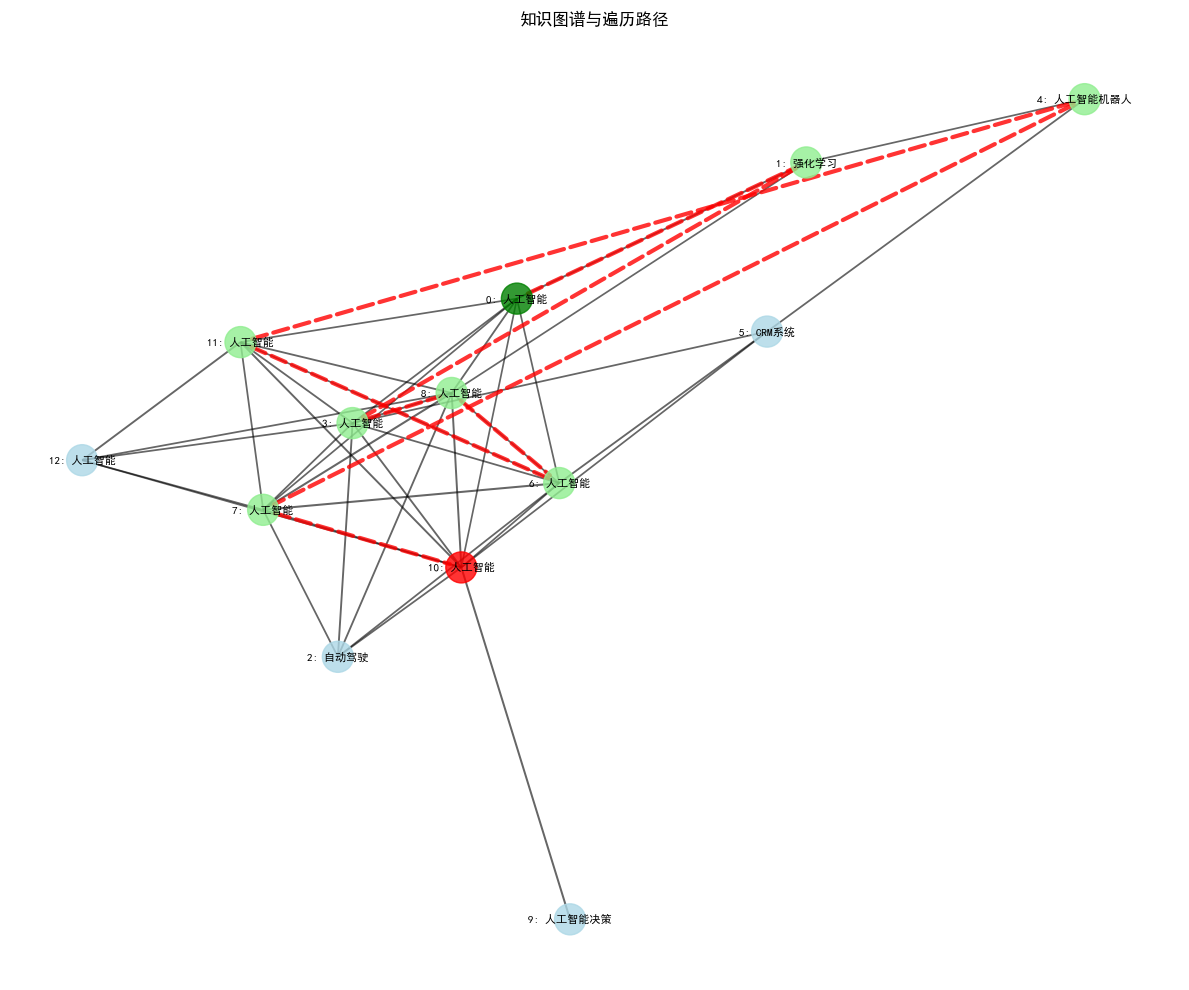


=== 回答 ===
根据提供的上下文，虽然没有直接提到"变压器(Transformers)"这个具体术语，但可以从自然语言处理(NLP)的相关内容中推断其关键应用。以下是基于上下文中NLP应用场景的总结：

1. 机器翻译（上下文明确提到）
上下文引用："NLP技术广泛应用于...机器翻译"（第2章）

2. 文本生成与内容创作
上下文引用："人工智能用于撰写文章、生成内容和创作脚本"（第9章）

3. 情感分析
上下文引用："RNN非常适合...情感分析等任务"（第2章）
上下文引用："NLP技术广泛应用于...情感分析"（第2章）

4. 聊天机器人
上下文引用："NLP技术广泛应用于聊天机器人"（第2章）

5. 文本摘要
上下文引用："NLP技术广泛应用于...文本摘要"（第2章）

需要说明的是，虽然Transformer架构是现代NLP的核心技术（如BERT、GPT等模型的基础），但上下文中并未明确提及该术语，上述应用是基于Transformer模型在NLP领域的实际应用与上下文描述的自然语言处理应用场景的对应关系得出的结论。
Created 13 text chunks
正在构建知识图谱...
正在为片段创建嵌入...
正在将节点添加到图中...
正在从片段 1/13 中提取概念...
正在从片段 2/13 中提取概念...
正在从片段 3/13 中提取概念...
正在从片段 4/13 中提取概念...
正在从片段 5/13 中提取概念...
正在从片段 6/13 中提取概念...
正在从片段 7/13 中提取概念...
正在从片段 8/13 中提取概念...
正在从片段 9/13 中提取概念...
正在从片段 10/13 中提取概念...
正在从片段 11/13 中提取概念...
正在从片段 12/13 中提取概念...
正在从片段 13/13 中提取概念...
正在在节点之间创建边...
知识图谱已构建，包含 13 个节点和 49 条边


=== 正在评估问题 1/1 ===
问题: 与 RNN 相比，变压器（Transformers）如何处理序列数据？
正在为查询遍历图: 与 RNN 相比，变压器（Transformers）如何处理序列数据？
从 5 个节点开始遍历
图遍历找到了 11 个相关片段

回答: 根据提供的上下文，虽然文中详细介

In [16]:
# 定义一个与 AI 相关的查询，用于测试 Graph RAG 系统
query = "自然语言处理中变压器（Transformers）的关键应用是什么？"

# 执行 Graph RAG 管道以处理文档并回答查询
results = graph_rag_pipeline(pdf_path, query)

# 打印由 Graph RAG 系统生成的回答
print("\n=== 回答 ===")
print(results["response"])

# 定义测试查询和参考答案以进行正式评估
test_queries = [
    "与 RNN 相比，变压器（Transformers）如何处理序列数据？"
]

# 用于评估的参考答案
reference_answers = [
    "变压器（Transformers）通过使用自注意力机制而不是循环连接来处理序列数据，这使得变压器能够并行处理所有标记，而不是顺序处理。这样可以更有效地捕获长距离依赖关系，并在训练期间实现更好的并行化。与 RNN 不同，变压器不会在长序列上遇到梯度消失问题。"
]

# 使用测试查询对 Graph RAG 系统进行正式评估
evaluation = evaluate_graph_rag(pdf_path, test_queries, reference_answers)

# 打印评估汇总统计信息
print("\n=== 评估汇总 ===")
print(f"图节点数: {evaluation['graph_stats']['nodes']}")
print(f"图边数: {evaluation['graph_stats']['edges']}")
for i, result in enumerate(evaluation['results']):
    print(f"\n查询 {i+1}: {result['query']}")
    print(f"遍历路径长度: {result['traversal_path_length']}")
    print(f"使用的相关块数: {result['relevant_chunks_count']}")
